# 2 - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation

In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). This model will achieve improved test perplexity whilst only using a single layer RNN in both the encoder and the decoder.

## Introduction

Let's remind ourselves of the general encoder-decoder model.

![](assets/seq2seq1.png)

We use our encoder (green) over the embedded source sequence (yellow) to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

In the previous model, we used an multi-layered LSTM as the encoder and decoder.

![](assets/seq2seq4.png)

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. By alleviating some of this information compression, we can create a better model!

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). Why? Mainly because that's what they did in the paper (this paper also introduced GRUs) and also because we used LSTMs last time. To understand how GRUs (and LSTMs) differ from standard RNNS, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) link. Is a GRU better than an LSTM? [Research](https://arxiv.org/abs/1412.3555) has shown they're pretty much the same, and both are better than standard RNNs. 

## Preparing Data

All of the data preparation will be (almost) the same as last time, so we'll very briefly detail what each code block does. See the previous notebook for a recap.



### Import all the required modules.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

#from torchtext.legacy.datasets import Multi30k

from torchtext.legacy.data import Field, BucketIterator

from torchtext.datasets import Multi30k 
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import spacy
import numpy as np

import random
import math
import time

Then set a random seed for deterministic results/reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!pip install spacy --upgrade

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


In [4]:
%%bash
python -m spacy download en
python -m spacy download de

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


2021-07-01 18:44:31.238337: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-01 18:44:36.650667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instantiate our German and English spaCy models. # rerun

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

#### We create the source and target language tokenizers.

In [6]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Yield function for source and target tokens

In [7]:
def yield_src_tokens(data_iter):
    for srctext , _ in data_iter:
        #print("src")
        yield tokenize_en(srctext)

def yield_tgt_tokens(data_iter):
  
    for _, tgttext in data_iter:
        #print("tgt",tgttext)
        yield tokenize_de(tgttext)

       

### Build Vocab function for source and target sentence

* using build_vocab_from_iterator function

In [8]:
def buildsrcvocab(data):
  vocab = build_vocab_from_iterator(yield_src_tokens(data), specials=["<unk>"])
  vocab.set_default_index(vocab["<unk>"])

  return vocab

def buildtgtvocab(data):
  vocab = build_vocab_from_iterator(yield_tgt_tokens(data), specials=["<unk>"])
  vocab.set_default_index(vocab["<unk>"])

  return vocab   


### Create source vocab 

* for train , valid and test data

In [9]:
train_data, valid_data, test_data = Multi30k()
print(len(train_data) , len(valid_data), len(test_data))
srcvocabtrain = buildsrcvocab(train_data)
srcvocabvalid = buildsrcvocab(valid_data)
srcvocabtest = buildsrcvocab(test_data)


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 968kB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 166kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 156kB/s]


29000 1014 1000


### Create target vocab 

* for train , valid and test data

In [10]:
train_data, valid_data, test_data = Multi30k()

tgtvocabtrain = buildtgtvocab(train_data)
tgtvocabvalid = buildtgtvocab(valid_data)
tgtvocabtest = buildtgtvocab(test_data)

#### create lambda function for source and target text pipeline

* for train , valid and test data

In [11]:
src_text_pipeline_train = lambda x: srcvocabtrain(tokenize_en(x))
tgt_text_pipeline_train = lambda x: tgtvocabtrain(tokenize_de(x))


In [12]:
src_text_pipeline_valid = lambda x: srcvocabvalid(tokenize_en(x))
tgt_text_pipeline_valid = lambda x: tgtvocabvalid(tokenize_de(x))


In [13]:
src_text_pipeline_test = lambda x: srcvocabtest(tokenize_en(x))
tgt_text_pipeline_test = lambda x: tgtvocabtest(tokenize_de(x))


set the device

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Collate batch function

For each batch iterate through the source and target text

* tokenize the text and get the index of the word in the vocab

* store as a tensor

* save the tensor in a list

* also store the string length in an array , 

* this is the offset of each sentence in an 1 D array of all sentences.

* concatenate the source text to create 1 D array of sentence , this will be fed to embedding bag , this is a much effecient way of processing text.

* pad the target sentence to make them all of equal length , this will be fed to the decoder , word by word.

#### There are 3 collate batch function , one each for train , valid and test data

In [15]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch_train(batch):
    tgt_list, src_list, src_offsets, tgt_offsets = [], [], [0], [0]
    for (_tgttext, _srctext) in batch:
         srcprocessed_text = torch.tensor(src_text_pipeline_train(_srctext), dtype=torch.int64)
         src_list.append(srcprocessed_text)
         src_offsets.append(srcprocessed_text.size(0))
         tgtprocessed_text = torch.tensor(tgt_text_pipeline_train(_tgttext), dtype=torch.int64)
         tgt_list.append(tgtprocessed_text)
         tgt_offsets.append(tgtprocessed_text.size(0))
         
    src_offsets = torch.tensor(src_offsets[:-1]).cumsum(dim=0)
    tgt_offsets = torch.tensor(tgt_offsets[:-1]).cumsum(dim=0)
    src_list = torch.cat(src_list)
    tgt_list = pad_sequence(tgt_list)
    
    
    return src_list.to(device), tgt_list.to(device), src_offsets.to(device), tgt_offsets.to(device)    

def collate_batch_valid(batch):
    tgt_list, src_list, src_offsets, tgt_offsets = [], [], [0], [0]
    for (_tgttext, _srctext) in batch:
         srcprocessed_text = torch.tensor(src_text_pipeline_valid(_srctext), dtype=torch.int64)
         src_list.append(srcprocessed_text)
         src_offsets.append(srcprocessed_text.size(0))
         tgtprocessed_text = torch.tensor(tgt_text_pipeline_valid(_tgttext), dtype=torch.int64)
         tgt_list.append(tgtprocessed_text)
         tgt_offsets.append(tgtprocessed_text.size(0))
         
    src_offsets = torch.tensor(src_offsets[:-1]).cumsum(dim=0)
    tgt_offsets = torch.tensor(tgt_offsets[:-1]).cumsum(dim=0)
    src_list = torch.cat(src_list)
    tgt_list = pad_sequence(tgt_list)
    return src_list.to(device), tgt_list.to(device), src_offsets.to(device), tgt_offsets.to(device)    


def collate_batch_test(batch):
    tgt_list, src_list, src_offsets, tgt_offsets = [], [], [0], [0]
    for (_tgttext, _srctext) in batch:
         srcprocessed_text = torch.tensor(src_text_pipeline_test(_srctext), dtype=torch.int64)
         src_list.append(srcprocessed_text)
         src_offsets.append(srcprocessed_text.size(0))
         tgtprocessed_text = torch.tensor(tgt_text_pipeline_test(_tgttext), dtype=torch.int64)
         tgt_list.append(tgtprocessed_text)
         tgt_offsets.append(tgtprocessed_text.size(0))
         
    src_offsets = torch.tensor(src_offsets[:-1]).cumsum(dim=0)
    tgt_offsets = torch.tensor(tgt_offsets[:-1]).cumsum(dim=0)
    src_list = torch.cat(src_list)
    tgt_list = pad_sequence(tgt_list)
    return src_list.to(device), tgt_list.to(device), src_offsets.to(device), tgt_offsets.to(device)            

## Building the Seq2Seq Model

### Encoder

The encoder is similar to the previous one, with the multi-layer LSTM swapped for a single-layer GRU. We also don't pass the dropout as an argument to the GRU as that dropout is used between each layer of a multi-layered RNN. As we only have a single layer, PyTorch will display a warning if we try and use pass a dropout value to it.

Another thing to note about the GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})\\
h_t &= \text{RNN}(e(x_t), h_{t-1})
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). Again, for more info, check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post. 

The rest of the encoder should be very familar from the last tutorial, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

This is identical to the encoder of the general seq2seq model, with all the "magic" happening inside the GRU (green).

![](assets/seq2seq5.png)

### Encoder 

* it uses embeddingbag function , which takes a batch of sentences as a 1 D array along with the offset of each sentence

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.EmbeddingBag(input_dim, emb_dim,sparse=True) #no dropout as only one layer!
        
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,offsets):
        
        #src = [src len, batch size]
        #print('encr embd' ,src.shape , offsets.shape)        
        embedded = self.dropout(self.embedding(src,offsets))
        embedded =embedded.unsqueeze(0)
        #embedded = [src len, batch size, emb dim]
        
        #print('encr - embed shape',embedded.shape)
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        #print('encr - rnn out shape',outputs.shape, hidden.shape)
        return hidden

## Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$

Note how this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder. 

Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as $\hat{y}_{t+1}=f(s_t^L)$. Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

Thus, our decoder now looks something like this:

![](assets/seq2seq6.png)

Note, the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that says differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!

Within the implementation, we will pass $d(y_t)$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `emb_dim + hid_dim` (as context vector will be of size `hid_dim`). The linear layer will take $d(y_t), s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dim + hid_dim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `emb_con` before feeding to the GRU, and we concatenate $d(y_t)$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

### Decoder implementation

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
            
        #emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        #output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden

## Seq2Seq Model

Putting the encoder and decoder together, we get:

![](assets/seq2seq7.png)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

### Seq2seq model implementation

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, srcoffset, trgoffset, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        #print(trg.shape)
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is the context
        context = self.encoder(src, srcoffset)
        
        #context also used as the initial hidden state of the decoder
        hidden = context
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        #output, hidden = self.decoder(trg, trgoffset, hidden, context)

        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs # outputs

# Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one. 

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

### create an instance of the model

In [19]:
INPUT_DIM = len(srcvocabtrain)   #len(SRC.vocab)
OUTPUT_DIM = len(tgtvocabtrain)    #len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [20]:
print(OUTPUT_DIM)

11396


Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): EmbeddingBag(18542, 256, mode=mean)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(11396, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=11396, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We print out the number of parameters.

Even though we only have a single layer RNN for our encoder and decoder we actually have **more** parameters  than the last model. This is due to the increased size of the inputs to the GRU and the linear layer. However, it is not a significant amount of parameters and causes a minimal amount of increase in training time (~3 seconds per epoch extra).

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,414,276 trainable parameters


### Utility function to train and evaluate

In [23]:
import time

def train(dataloader , clip):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    epoch_loss = 0

    for idx, (src, tgt, src_offsets, tgt_offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        #print('train' ,src.shape , tgt.shape )
        predicted = model(src, tgt, src_offsets, tgt_offsets)
        
        output_dim = predicted.shape[-1]
        
        #print('pred ' ,predicted.shape , tgt.shape )

        predicted = predicted[1:].view(-1, output_dim)
        tgt = tgt[1:].view(-1)
        #print('pred after ' ,predicted.shape , tgt.shape )
        
        loss = criterion(predicted, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        return epoch_loss / len(dataloader)


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    epoch_loss = 0
    with torch.no_grad():
        for idx, (src, tgt, src_offsets, tgt_offsets) in enumerate(dataloader):
        
            predicted = model(src, tgt, src_offsets, tgt_offsets , 0)

            output_dim = predicted.shape[-1]
        
            predicted = predicted[1:].view(-1, output_dim)
            tgt = tgt[1:].view(-1)
            loss = criterion(predicted, tgt)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)




...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

We'll also define the function that calculates how long an epoch takes.

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Then, we train our model, saving the parameters that give us the best validation loss.

In [25]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 #10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training
CLIP = 1

trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

best_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
#train_iter, test_iter = AG_NEWS()
train_iter, valid_iter, test_iter = Multi30k()

train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch_train)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch_valid)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch_test)

for epoch in range(1, EPOCHS + 1):
    
    start_time = time.time()
    
    train_loss = train(train_dataloader,CLIP)
    valid_loss = evaluate(valid_dataloader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'multi30k-model.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(math.exp(train_loss),2))
    valAccyList.append(round(math.exp(valid_loss),2))


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    
    print('-' * 59)

Epoch: 02 | Time: 0m 1s
	Train Loss: 0.021 | Train PPL:   1.021
	 Val. Loss: 4.658 |  Val. PPL: 105.406
-----------------------------------------------------------
Epoch: 03 | Time: 0m 1s
	Train Loss: 0.010 | Train PPL:   1.010
	 Val. Loss: 3.094 |  Val. PPL:  22.069
-----------------------------------------------------------
Epoch: 04 | Time: 0m 1s
	Train Loss: 0.008 | Train PPL:   1.008
	 Val. Loss: 6.342 |  Val. PPL: 567.922
-----------------------------------------------------------
Epoch: 05 | Time: 0m 1s
	Train Loss: 0.014 | Train PPL:   1.014
	 Val. Loss: 1.419 |  Val. PPL:   4.135
-----------------------------------------------------------
Epoch: 06 | Time: 0m 1s
	Train Loss: 0.003 | Train PPL:   1.003
	 Val. Loss: 2.005 |  Val. PPL:   7.424
-----------------------------------------------------------
Epoch: 07 | Time: 0m 1s
	Train Loss: 0.005 | Train PPL:   1.005
	 Val. Loss: 1.520 |  Val. PPL:   4.570
-----------------------------------------------------------
Epoch: 08 | Time

### A plot of model performance

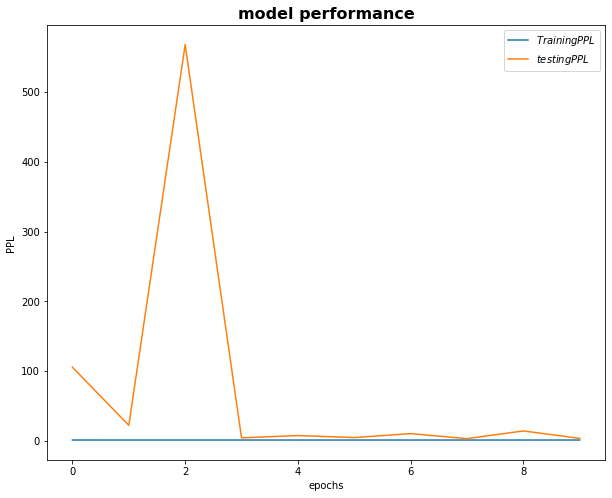

In [26]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training PPL $" )
plt.plot(xpoints, ypoints6, label = "$ testing PPL $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("PPL ")
plt.show()

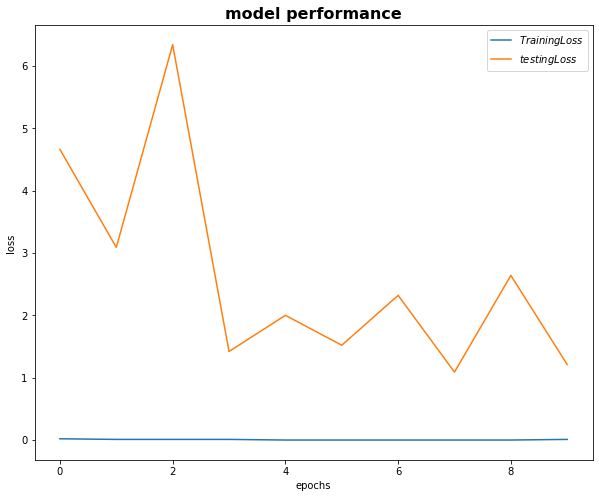

In [27]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

### Finally, we test the model on the test set using these "best" parameters.

In [28]:
model.load_state_dict(torch.load('multi30k-model.pt'))

test_loss = evaluate(test_dataloader)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')



| Test Loss: 1.117 | Test PPL:   3.055 |


Just looking at the test loss, we get better performance than the previous model. This is a pretty good sign that this model architecture is doing something right! Relieving the information compression seems like the way forward, and in the next tutorial we'll expand on this even further with *attention*.